<a href="https://colab.research.google.com/github/akshay-121/SURP-Animal-species-detection-from-videos/blob/main/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
import cv2
from math import *
optimizer = tf.keras.optimizers.Adam()


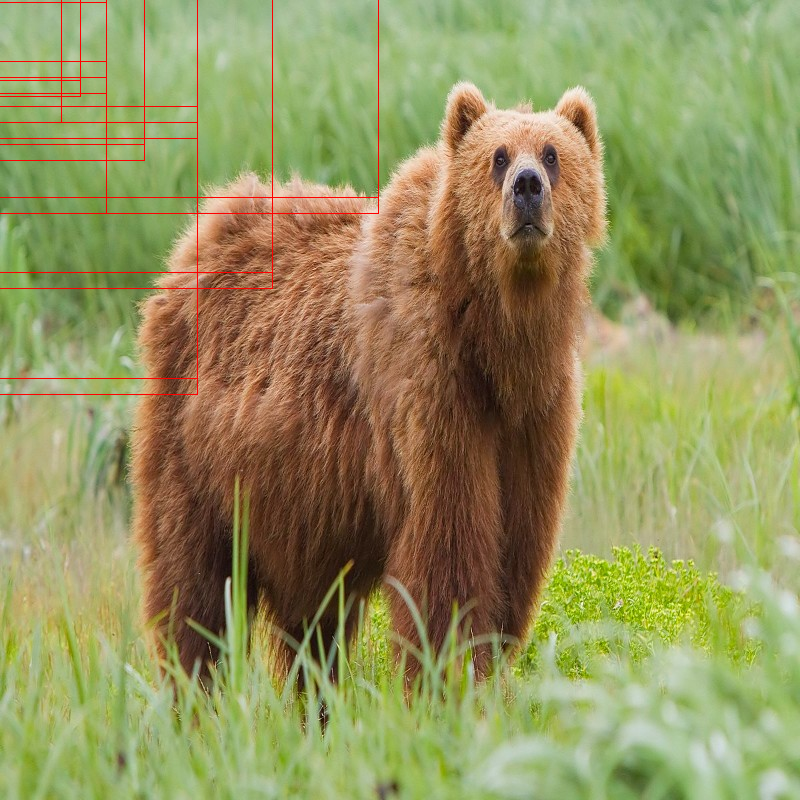

In [ ]:
im=cv2.imread('temp.jpg')
for box in anchors[:20]:
    cv2.rectangle(im,(int(box[0]),int(box[1])),(int(box[0]+box[2]),int(box[1]+box[3])),(0,0,255),(1))
cv2_imshow(im)

In [ ]:
ctrx=np.arange(16,(50*16+1),16)
ctry=np.arange(16,(50*16+1),16)
ctr=[]
for i in ctrx:
    for j in ctry:
        ctr.append([i,j])
from math import sqrt
anchors_ratio=[0.5,1.0,2.0]
anchors_scale=[8,16,32]                                                 #anchors setup
anchors=[]
for c in ctr:
    for i in anchors_ratio:
        for j in anchors_scale:
            h=16*j*sqrt(i)
            w=16*j*sqrt(1.0/i)
            x=c[0]-w/2.0
            y=c[1]-h/2.0
            #if x>=0 and y>=0 and x+w<800 and y+h<800:
            anchors.append([x,y,w,h])



In [ ]:
def iou(box_a,box_b):
    y1=max(box_a[1],box_b[1])
    y2=min(box_a[1]+box_a[3],box_b[1]+box_b[3])
    x1=max(box_a[0],box_b[0])
    x2=min(box_a[0]+box_a[2],box_b[0]+box_b[2])
    if y1>y2 or x1>x2:
        return 0                                                    #iou calculation
    inter_area=(x2-x1)*(y2-y1)
    union_area=box_a[2]*box_a[3]+box_b[2]*box_b[3]-inter_area
    if union_area == 0:
        return 0
    return inter_area/union_area


In [ ]:
x=Input((800,800,3))
inp=x
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(800,800,3))
for layer in vgg.layers:
    layer.trainable=False
    if layer.__class__.__name__ == 'InputLayer':                               
        continue
    if layer.output_shape[1]>=50:
        x=layer(x)
feature_map=x
model=Model(inp,feature_map)
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 800, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 800, 800, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 800, 800, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 400, 400, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 400, 400, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 400, 400, 128)     147584    
______________________________________________________________

In [ ]:
np.shape(anchors)

(22500, 4)

In [ ]:
x=Conv2D(512,(3,3),padding='same')(feature_map)
reg_boxes=Conv2D(36,1)(x)
reg_boxes=Reshape((2500*9,4))(reg_boxes)
cls=Conv2D(18,1)(x)
cls=Reshape((2500*9,2))(cls)
cls=Softmax()(cls)
res_layer=Concatenate()([reg_boxes,cls])


In [ ]:
rpn=Model(inputs=inp,outputs=res_layer)
rpn.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 800, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 800, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 800, 800, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 400, 400, 64) 0           block1_conv2[1][0]               
____________________________________________________________________________________________

In [ ]:
def l1_loss(x,y):
    if abs(x-y)<1:
        return (x-y)**2
    return abs(x-y)

In [ ]:
import sys
def loss_rpn(gt_boxes,predicted):
    scores=predicted[0][:,4:]                               #gt_boxes = the original bounding box (y_test)
    boxes=predicted[0][:,:4]
    good=[]
    bad=[]
    curr=0
    match=[0]*len(anchors)
    for i in range(len(anchors)):
        for j in range(len(gt_boxes)):
            overlap=iou(anchors[i],gt_boxes[j])
            if overlap>curr:
                curr=overlap
                box=i
            if overlap>=0.7:
                good.append(i)
                match[i]=j
            if overlap<=0.3:
                bad.append(i)
    samp=min(512,len(good))
    c1=np.random.choice(good,samp,False)
    c2=np.random.choice(bad,1024-samp,False)
    good_boxes=np.array(anchors)[c1]
    bad_boxes=np.array(anchors)[c2]
    tempc1=[]
    tempc2=[]
    for k in c1:
        tempc1.append([k])
    for k in c2:
        tempc2.append([k])
    pred_boxes=tf.gather_nd(boxes,tempc1)
    pred_scores=tf.gather_nd(scores,tempc1)
    bad_scores=tf.gather_nd(scores,tempc2)
    selected_gt=np.array(gt_boxes)[np.array(match)[c1].astype(int)]
    #print(selected_gt)
    reg_loss=0.0
    cls_loss=0.0
    #print(np.shape(pred_scores),np.shape(good_boxes))
    #print(pred_scores[51])
    #print('good')
    #print(pred_scores)
    #print('bad')
    #print(bad_scores)
    for i in range(len(good_boxes)):
        tx=pred_boxes[i][0]/good_boxes[i][2]
        ty=pred_boxes[i][1]/good_boxes[i][3]
        th=log(abs((pred_boxes[i][3]+good_boxes[i][3])/good_boxes[i][3]))
        tw=log(abs((good_boxes[i][2]+pred_boxes[i][2])/good_boxes[i][2]))

        tx_star=(selected_gt[i][0]-good_boxes[i][0])/(good_boxes[i][2])
        ty_star=(selected_gt[i][1]-good_boxes[i][1])/(good_boxes[i][3])
        th_star=log(selected_gt[i][3]/good_boxes[i][3])
        tw_star=log(selected_gt[i][2]/good_boxes[i][2])

        reg_loss+=l1_loss(tx,tx_star)+l1_loss(ty,ty_star)+l1_loss(tw,tw_star)+l1_loss(th,th_star)
        cls_loss+=-(log(1e-20+pred_scores[i][0]))
    #print('good cls',cls_loss)

    #for i in range(len(bad_boxes)):
     #   cls_loss+=-(log(1e-20+bad_scores[i][1]))
   # print('bad cls',cls_loss)
    return 1000*reg_loss+1/600*cls_loss,c1

    

In [ ]:
temp=[]

In [ ]:
def train_rpn(img,gt_boxes):
    with tf.GradientTape() as tape:
        pred_boxes=rpn(img)
        loss,ccc=loss_rpn(gt_boxes,pred_boxes)
    grads=tape.gradient(loss,rpn.trainable_variables)
    optimizer.apply_gradients(zip(grads,rpn.trainable_variables))
    temp.append(ccc)
    del tape

    return loss


In [ ]:
def get_labels_for_roi(gt_boxes,rois):
    label=[]
    for roi in rois:
        curr=-1
        for gt_box in gt_boxes:
            temp=iou(gt_box[0],roi)
            if temp>curr:
                curr=temp
                box=gt_box[0]
                cls=gt_box[1]
        label.append([box,cls])
    return label        

In [ ]:
def roi_pooling(rois,fmaps):
    results=[]
    for i in range(2000):
        x,y,w,h=rois[i]//16.0
        a=[]
        for fmap in fmaps:
            projection=fmap[y:y+h,x:x+w]
            proj=cv2.resize(projection,(14,14),interpolation=cv2.INTER_CUBIC)
            a.append(proj)
        results.append(a)
    return results

In [ ]:
y=Input((2000,14,14,512))
y_inp=y
y=MaxPool3D((1,2,2))(y)
y=Reshape((2000,25088))(y)
y=Dense(1024)(y)
y=Dense(1024)(y)
final_reg=Dense(4)(y)
final_cls=Dense(2,activation='softmax')(y)
mod=Model(y_inp,[final_reg,final_cls])
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2000, 14, 14 0                                            
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 2000, 7, 7, 5 0           input_3[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2000, 25088)  0           max_pooling3d[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 2000, 1024)   25691136    reshape[0][0]                    
____________________________________________________________________________________________

In [ ]:
from google.colab.patches import cv2_imshow
tt=cv2.imread('temp.jpg')
tt=np.reshape(tt,(1,800,800,3))


In [ ]:
losses=[]
def train():
    img=cv2.imread('temp.jpg')
    img=np.reshape(img,(1,800,800,3))
    gt_boxes=[[125,75,613-125,730-75]]
    for i in range(50):
        l=train_rpn(img,gt_boxes)
        print(l.numpy())
        losses.append([i,l.numpy()])


        

In [ ]:
train()

2389.2698
2389.27
2389.2698
2389.2698
2389.2698
2389.2698
2389.27
2389.2695
2389.2698
2389.2703
2389.27
2389.27
2389.2698
2389.2695
2389.2698
2389.2698
2389.27
2389.2698
2389.2698
2389.2698
2389.27
2389.2698
2389.2698
2389.2698
2389.2698
2389.27
2389.2703
2389.2698
2389.27
2389.2698
2389.2695
2389.2703
2389.27
2389.2703
2389.2703
2389.27
2389.27
2389.27
2389.2703
2389.2703
2389.2705
2389.27
2389.2705
2389.2698
2389.2703
2389.2703
2389.2703
2389.2705
2389.2695
2389.2703


In [ ]:
temp

[array([10580, 10121, 11057,  9689, 10094, 10616, 10553,  9644, 11012,
         9653,  9662,  9635,  9626, 10130, 10589, 11003, 11030, 10148,
        10985,  9698,  9716, 10544, 10085, 10598, 10994, 10607, 10535,
        10157, 10526, 10076, 10139, 10103, 10166,  9707, 11021, 10571,
        10112, 10562,  9671, 11048, 11039,  9680]),
 array([ 9698, 10544,  9653, 10148,  9689,  9644, 11003, 11048, 10166,
        10076, 10616, 10553, 10526, 11039, 10139, 10562, 11030,  9716,
        10598, 10994, 10571, 10121, 10112,  9680, 11021,  9671, 10985,
        11057, 10130, 11012,  9635, 10157, 10535, 10589,  9626,  9707,
        10103, 10085,  9662, 10094, 10580, 10607]),
 array([11039, 10985, 10094, 10544,  9626, 10598, 10121, 10616, 10607,
        10157,  9644, 10085, 10580,  9671,  9689, 10130,  9707, 10562,
        10103,  9680, 11003, 10553,  9716, 10076, 10166, 11057, 10148,
         9653, 11030,  9662, 10535, 10112, 10526,  9635, 11012,  9698,
        10571, 11021, 10139, 10994, 11048, 1

In [ ]:
temp[4]

array([ 9626, 10157,  9662, 11012, 10094, 11039, 10526,  9716,  9635,
        9707, 10553, 10166, 11057, 10589, 10598, 10562, 10139, 10535,
       10985, 10994, 11003,  9653, 10103, 10580,  9689, 10112, 10571,
       10607, 10121,  9680, 10076,  9671,  9644, 10616, 10148, 11048,
        9698, 11021, 10085, 10544, 10130, 11030])

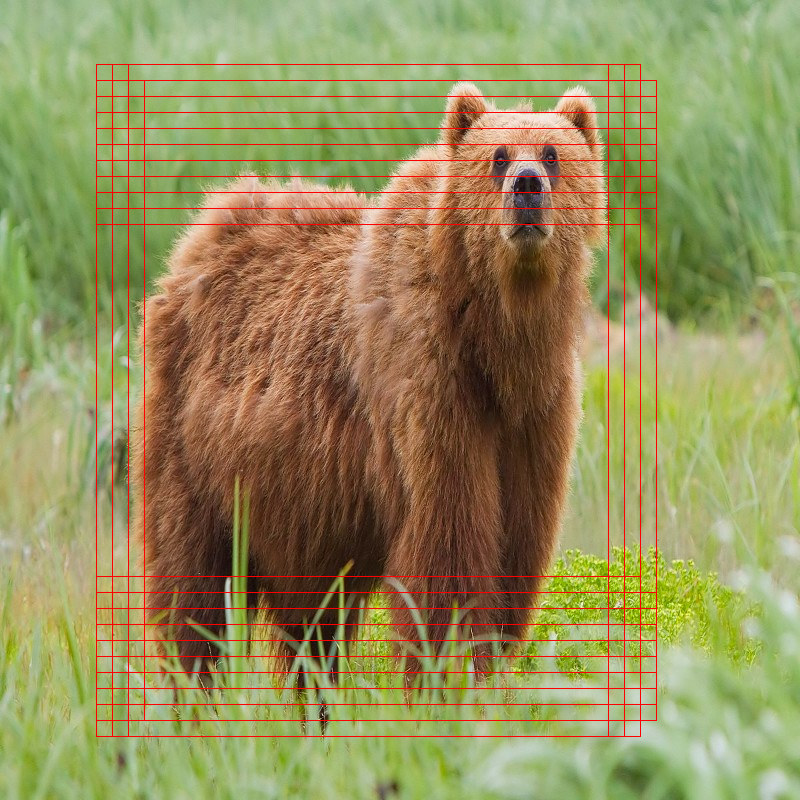

In [ ]:
im=cv2.imread('temp.jpg')
for bb in temp[4]:
    b=anchors[bb]
    cv2.rectangle(im,(int(b[0]),int(b[1])),(int(b[0]+b[2]),int(b[1]+b[3])),(0,0,255),1)
cv2_imshow(im)

In [ ]:
res=rpn.predict(tt)

In [ ]:
np.shape(anchors)

(22500, 4)

In [ ]:
res=list(zip(res[0],anchors))

In [ ]:
sorted(res)

(array([-9.3353186e+00,  1.4461517e+00, -7.6206698e+00, -8.5511190e-01,
         2.2803955e-03,  9.9771959e-01], dtype=float32),
 [-74.50966799187809,
  -29.254833995939045,
  181.01933598375618,
  90.50966799187809])

In [ ]:
im=cv2.imread('temp.jpg')
for pred,anc in sorted(res,key=lambda x:x[0][4],reverse=True)[:20]:
    print(pred[4])
    cv2.rectangle(im,(int(anc[0]+pred[0]),int(anc[1]+pred[1])),(int(anc[0]+pred[0]+anc[2]+pred[2]),int(anc[1]+pred[1]+anc[3]+pred[3])),(0,0,255),1)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


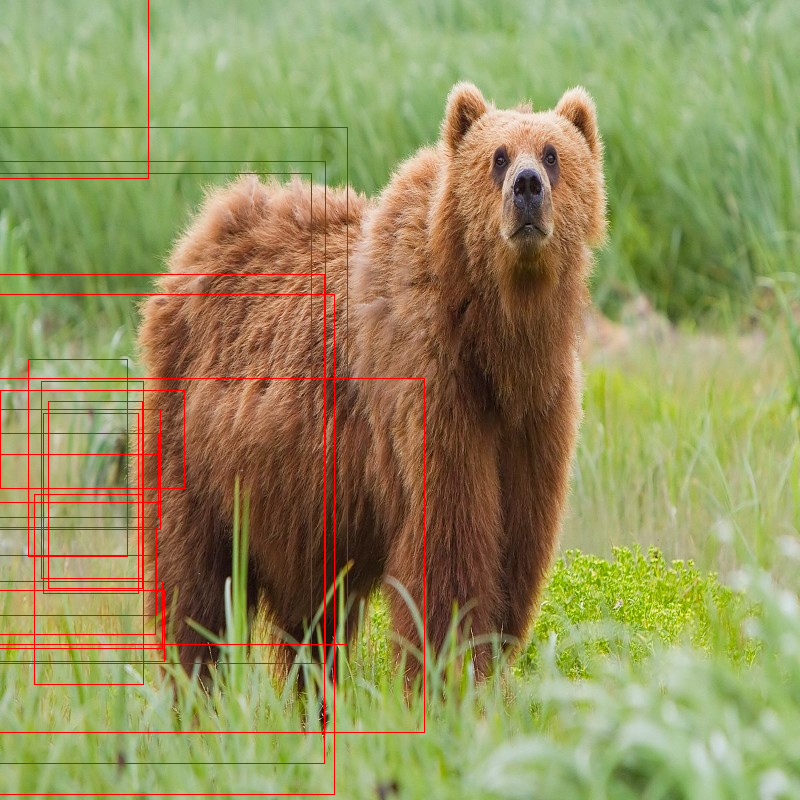

In [ ]:
cv2_imshow(im)

In [ ]:
cv2.rectangle(im,(125,75),(613,730),(255,0,0),1)

array([[[131, 181, 147],
        [131, 181, 147],
        [131, 180, 148],
        ...,
        [149, 188, 163],
        [149, 188, 163],
        [149, 188, 163]],

       [[131, 181, 147],
        [131, 181, 147],
        [130, 179, 147],
        ...,
        [151, 190, 165],
        [151, 190, 165],
        [151, 190, 165]],

       [[132, 182, 148],
        [131, 181, 147],
        [130, 179, 147],
        ...,
        [153, 192, 167],
        [153, 192, 167],
        [153, 192, 167]],

       ...,

       [[ 96, 172, 138],
        [ 93, 169, 135],
        [ 92, 167, 135],
        ...,
        [147, 197, 167],
        [149, 197, 169],
        [152, 197, 170]],

       [[ 98, 172, 138],
        [ 97, 171, 137],
        [ 97, 170, 138],
        ...,
        [146, 196, 166],
        [147, 195, 167],
        [148, 196, 168]],

       [[ 97, 171, 137],
        [ 98, 172, 138],
        [101, 174, 142],
        ...,
        [143, 195, 165],
        [146, 194, 166],
        [146, 194, 166]]